<a href="https://colab.research.google.com/github/kushalkrd/computational_economics/blob/main/Projects/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2

Project is to write a genetic algorithm that solves the optimal investment pattern in the health care experiment. Below are the details of the experiment and the parameters from the class

### General Aspects
- There will be 10 periods. Players begin with 70 health.
- Each period, the player harvests some amount of money (this amount is detailed below)
- After harvesting, the player's health degenerates (this amount is detailed below)
- After health degeneration, the player must spend money on Health Investments and Life Investments. Money spent on Health Investments increases health, while money spent on Life Investments gives the player Life Enjoyment. Any money not spent carries over into the next period.
- A player dies if their health ever goes below 0. If a player dies, they receive 0 Life Enjoyment for the remaining periods.
- The goal is to maximize total Life Enjoyment across all periods.
 

### Functions
 

#### Harvesting:
1. The player earns income by harvesting black dots in a region designated by M x N cells. In our parameters (M = N = 100)
2. The player can select any set of contiguous W columns to harvest. In our parameters (W = 10)
3. When fully healthy, there are T black dots dispersed across M x W cells each period. Each black dot is worth v. In our parameters T = 100 and v = 1
4. The number of rows that can be harvested each period are given by: 
$$ HarvestRows(H) = M  (1 - \gamma \frac{100 - H}{100})$$
 where (𝛾=1)

5. The number of rows are reduced by disabling the rows in the upper and lower regions of the selected columns.
6. With these parameters, if health is 50 at the start of the period, the player has only 500 cells in which they can harvest black dots. With 80 health, they have 800 cells.
 

#### Degeneration:
Each period, the player loses (10 + CurrentPeriod) in health. i.e. 11 health the first period, 12 the second period, up to 20 in the last period.


#### Health Regeneration:
The equation for the amount of health regained given a certain Health Investment, I, and health after harvesting, H, is given by: 

$$ \textrm{HealthRegained}(I,H)=100 \left(\frac{e^{k*I}}{e^{k*I} + \frac{100 - H}{H}}\right) - H $$


where (k = 0.01021).  Health cannot exceed 100, and is always rounded down to the nearest integer.

#### Life Enjoyment:
The equation for the amount of Life Enjoyment given a certain Life Investment, L, is given by: 

$$ \text{LifeEnjoyment}(L,\text{CurrentHealth})=c\left(\frac{\text{CurrentHealth}}{100}\right) \left(\frac{L}{L + \alpha}\right) $$

where (c = 464.53) and (𝛼=32)
(
α
=
32
)
.

CurrentHealth is the health the player has during the investment phase **INCLUDING** the amount regained this period through investments in health.

 

The first part of your grade will be based upon how well you can optimize this parameter set. On the due date, I will give a new set of parameters. You will have 1 hour to find the optimal investment pattern for this new set. Your algorithm's performance on this parameter set will determine the rest of your grade.

 

We can change any of the following:

- Harvesting grid size, selection width, dot density, and dot value.
- Regeneration parameters
- Life Enjoyment parameters
- Number of Periods
- Degeneration per period

*Pretty much anything.*

# Solution

## Class Parameters

In [154]:
class Params_healthcare:
  periods = 10
  init_health = 70
  M = 100
  N = 100
  T = 100
  W = 10
  degen = 10 
  health_max = 100 
  health_min = 0
  v = 1
  gamma = 1 
  k = 0.01021
  alpha = 32
  c = 464.53

class Params_ga:
  iterations = 100
  size_population = 100
  ratio_children = 0.05
  chance_mutate = 0.02

class Agent:
    """An Agent Class representing Each Agent"""
    def __init__(self, share_I, share_L, share_money, health, enjoyment, money):
        self.share_I = share_I
        self.share_L = share_L
        self.share_money = share_money
        self.health = health
        self.enjoyment = enjoyment
        self.money = money
    def update_self(self):
      for i in np.arange(1,len(self.share_I)):
        self.health[i]=self.health[i-1]+val_regenerate(params_healthcare,self.money[i-1]*self.share_I[i-1],self.health[i-1]) - val_degenerate(params_healthcare,i)
        self.enjoyment[i]= self.enjoyment[i-1]+life_enjoyment(params_healthcare,self.money[i-1]*self.share_L[i-1],self.health[i-1])
        self.money[i]=self.money[i-1]*self.money[i-1]+harvest(params_healthcare,self.health[i])
  

## Functions 

In [9]:
import numpy as np 
params_healthcare = Params_healthcare
params_ga = Params_ga

def harvest(params_healthcare,health):
  return params_healthcare.T * params_healthcare.v *(1 - (params_healthcare.gamma * ((100 - health) / 100)))

def val_regenerate(params_healthcare,I,health):
  ki_exp=np.exp(params_healthcare.k*I)
  value= np.floor(params_healthcare.health_max * ( ki_exp/(ki_exp+((params_healthcare.health_max-health)/health))) - health)
  if value < 0:
    value = 0 
  print(value)
  return value if value <params_healthcare.health_max else params_healthcare.health_max

def val_degenerate(params_healthcare,period):
  return params_healthcare.degen+period

def life_enjoyment(params_healthcare,L,health):
        return (L / (L + params_healthcare.alpha)) * params_healthcare.c * health / 100 


In [126]:
def generate_population(params_healthcare, params_ga):
  population=[]
  for i in np.arange(params_ga.size_population):
    a_health=[params_healthcare.init_health]
    a_enjoyment = [0]
    a_money = [harvest(params_healthcare,params_healthcare.init_health)]
    a_share_I = [0]
    a_share_L = [0]
    a_share_M = [0]
    for period in np.arange(params_healthcare.periods-1):
      if a_health[period]<=params_healthcare.health_min:
        a_share_I.append(0);
        a_share_L.append(0);
        a_share_M.append(0);
        a_health.append(a_health[period]);
        a_enjoyment.append(a_enjoyment[period]);
        a_money.append(a_money[period]);
      else:
        share_I=np.round(np.random.rand(),2);
        if share_I>=1:
          share_L=np.random.randint(0,100*(1.01-share_I))/100;
        else:
          share_L=np.random.randint(0,100*(1-share_I))/100;
        share_M=np.round(1-share_I-share_L,2);
        a_share_I.append(share_I);
        a_share_L.append(share_L);
        a_share_M.append(share_M);

        a_enjoyment.append(a_enjoyment[period]+life_enjoyment(params_healthcare,a_money[period]*share_L,a_health[period])) ;
        period_health = a_health[period] + val_regenerate(params_healthcare,a_money[period]*share_I,a_health[period]) - val_degenerate(params_healthcare,period)
        health = period_health if period_health > params_healthcare.health_min else 0 ;
        a_health.append(health);
        a_money.append(a_share_M[period]*a_money[period]+harvest(params_healthcare,health));
    population.append(Agent(a_share_I,a_share_L,a_share_M,a_health,a_enjoyment,a_money));
  return population
def show_population(agents_list):
   return [(agents.share_I,agents.share_L,agents.share_money,agents.health,agents.enjoyment,agents.money) for agents in agents_list ]



In [140]:
np.random.rand()*0.2

0.07431748352784955

In [149]:

def mutation(agent, probab_mutate):
    if random.random() < probab_mutate:
        add_value = np.random.rand()*0.2
        for i in np.arange(len(agent.share_I)):
            agent.share_I[i] = agent.share_I[i] + add_value if agent.share_I[i] + add_value <= 1 else 1
            agent.share_L[i] = agent.share_L[i] - add_value if agent.share_L[i] + add_value > 0 else 0
            agent.share_money[i] = 1- agent.share_L[i]-agent.share_I[i]
    agent.update_self()
    return agent 

def fitness(agent):      
    return agent.enjoyment[-1]

#Generate N solutions 

#crossover 

def crossover(p1,p2):
  random_ind=random.choice(range(len(p1.share_I)))
  c1=p1
  c2=p2
  c1.share_I= p1.share_I[:random_ind]+p2.share_I[random_ind:]
  c2.share_I= p2.share_I[:random_ind]+p1.share_I[random_ind:]
  c1.share_L= p1.share_L[:random_ind]+p2.share_L[random_ind:]
  c2.share_L= p2.share_L[:random_ind]+p1.share_L[random_ind:]
  c1.share_money= p1.share_money[:random_ind]+p2.share_money[random_ind:]
  c2.share_money= p2.share_money[:random_ind]+p1.share_money[random_ind:]

  return [c1,c2]

#return the selected parents 
def roullette_selection(population, num_parents=2):
  selected= random.sample(population,k=num_parents)

  crossed=crossover(selected[0],selected[1])
  mutated= [ mutation(x,0.02) for x in crossed]

  return mutated


def choose_m_children(population,m):
  children= [roullette_selection(population,2)[0] for x in range(m)]

  return children


def winner(s1,s2):
  val_s1= fitness(s1)
  val_s2= fitness(s2)
  return s1 if val_s1 > val_s2 else s2

def tournament_survival(population,N):
  new_pop=[]
  for i in range(N):
    s=random.sample(population,k=2)
    new_pop.append(winner(s[0],s[1]))
  return new_pop

9.0
8.0
8.0
7.0
11.0
2.0
9.0
2.0
0.0
9.0
10.0
8.0
3.0
6.0
9.0
3.0
0.0
0.0
1.0
2.0
11.0
10.0
9.0
12.0
5.0
4.0
1.0
7.0
12.0
11.0
6.0
12.0
0.0
10.0
9.0
6.0
9.0
5.0
13.0
7.0
9.0
8.0
13.0
7.0
3.0
6.0
1.0
8.0
19.0
15.0
1.0
2.0
0.0
4.0
0.0
2.0
4.0
3.0
4.0
3.0
0.0
7.0
5.0
0.0
13.0
16.0
3.0
7.0
1.0
1.0
8.0
3.0
15.0
4.0
11.0
2.0
10.0
0.0
0.0
9.0
11.0
12.0
12.0
9.0
2.0
1.0
10.0
9.0
8.0
1.0
11.0
9.0
8.0
14.0
3.0
7.0
1.0
3.0
9.0
13.0
7.0
12.0
8.0
6.0
9.0
8.0
2.0
11.0
17.0
2.0
10.0
2.0
6.0
10.0
0.0
6.0
11.0
3.0
8.0
18.0
7.0
1.0
0.0
2.0
0.0
6.0
13.0
11.0
0.0
7.0
9.0
2.0
1.0
7.0
10.0
10.0
1.0
0.0
4.0
7.0
6.0
0.0
11.0
10.0
2.0
0.0
1.0
6.0
6.0
0.0
4.0
12.0
11.0
12.0
9.0
5.0
8.0
1.0
3.0
8.0
12.0
7.0
12.0
15.0
7.0
10.0
3.0
10.0
5.0
12.0
8.0
2.0
19.0
7.0
11.0
9.0
0.0
7.0
4.0
1.0
4.0
11.0
4.0
1.0
0.0
8.0
7.0
11.0
7.0
13.0
18.0
15.0
11.0
11.0
8.0
10.0
13.0
5.0
11.0
18.0
1.0
7.0
6.0
11.0
12.0
10.0
6.0
13.0
17.0
8.0
11.0
6.0
5.0
4.0
3.0
20.0
18.0
11.0
0.0
10.0
8.0
9.0
10.0
5.0
10.0
13.0
9.0
12.0
10.0
4.0
2.0
1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars



40.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
2.0
39.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
2.0
39.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0
41.0
nan
nan
nan
nan
nan
nan
nan
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


Streaming output truncated to the last 5000 lines.
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan
nan
nan
nan
12.0
29.0
nan
nan
nan
nan

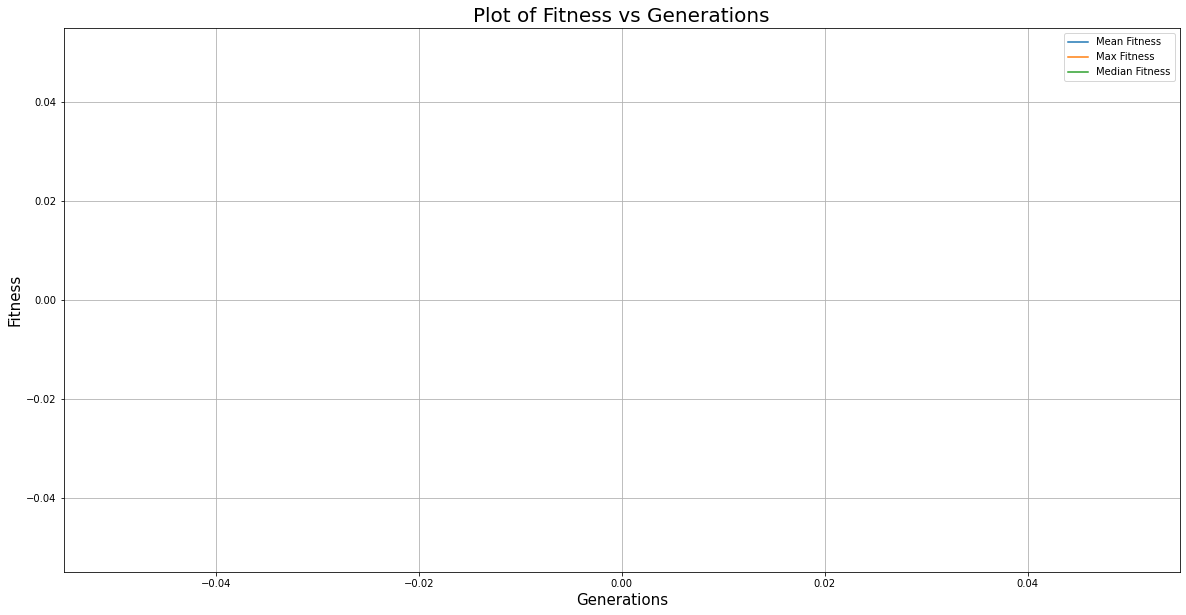

In [157]:
import matplotlib.pyplot as plt

# hotel problem parameters
build_time=2
periods=40
population_size=50
children=2
generations=1000

all_generations=[]
fitness_all=[]
population=generate_population(params_healthcare, params_ga)

for i in range(generations):
  if i ==0: 
    new_gen=population
  all_pop=new_gen+choose_m_children(new_gen,children)
  new_gen=tournament_survival(all_pop,population_size)
  fitness_all.append([fitness(x) for x in new_gen])
  all_generations.append(new_gen)

print("Fitness of final generation's first member is:")
print(fitness(all_generations[-1][0]))


fitness_all_mean = [np.mean(fitness) for fitness in fitness_all]
fitness_all_max = [np.max(fitness) for fitness in fitness_all]
fitness_all_min = [np.median(fitness) for fitness in fitness_all]

plt.figure(figsize=(20,10))
plt.grid()
plt.plot(list(range(generations)), fitness_all_mean, label = 'Mean Fitness')
plt.plot(list(range(generations)), fitness_all_max, label = 'Max Fitness')
plt.plot(list(range(generations)), fitness_all_min, label = 'Median Fitness')

plt.title('Plot of Fitness vs Generations',fontsize=20)
plt.legend()

plt.xlabel('Generations', fontsize=15)
plt.ylabel('Fitness', fontsize=15)
plt.savefig('fitness_generations.png')
plt.show()
